# Analysis of SARS-COV-2 virus neutalization in different Ace2 clones

### Set up Analysis

In [1]:
import itertools
import math
import os
import re
import warnings

from IPython.display import display, HTML

import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import natsort

import numpy as np
import pandas as pd
from plotnine import *
import seaborn

import neutcurve
from neutcurve.colorschemes import CBMARKERS, CBPALETTE

import yaml

In [2]:
warnings.simplefilter('ignore')

Read config file.

In [3]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

Set seaborn theme:

In [4]:
theme_set(theme_seaborn(style='white', context='talk', font_scale=1))
plt.style.use('seaborn-white')

In [5]:
resultsdir=config['resultsdir']
os.makedirs(resultsdir, exist_ok=True)

## Read in data

In [6]:
frac_infect = list() # create df list

for f in config['depletion_neuts'].keys():
    df = (pd.read_csv(f, index_col=0))
    frac_infect.append(df)  
frac_infect = pd.concat(frac_infect)

frac_infect['serum'] = frac_infect['serum'] + '__' + frac_infect['cells']
fits = neutcurve.CurveFits(frac_infect, fixbottom= False)

## Fit Hill curve to data using [`neutcurve`](https://jbloomlab.github.io/neutcurve/)

In [7]:
fitparams = (
    fits.fitParams()
    .rename(columns={'virus': 'depletion'})
    [['serum', 'depletion', 'ic50', 'ic50_bound']]
    .assign(NT50=lambda x: 1/x['ic50'])

    )

In [8]:
fitparams['ic50_is_bound'] = fitparams['ic50_bound'].apply(lambda x: True if x!='interpolated' else False)


In [9]:
#save data
fitparams.to_csv(config['neuts'], index=False)


In [10]:
fitparams[['sample', 'cells']] = fitparams['serum'].str.split('__', 1, expand=True)

fitparams = fitparams.rename(columns={"depletion": "RBD-targeting antibodies"})

In [11]:
#category for cell order so that ggplot does not use alphabetical
cat_order = ['very low', 'low', 'medium', 'high']
fitparams['category'] = pd.Categorical(fitparams['cells'], categories=cat_order, ordered=True)

cat_order_sera = ['63C-day-10', '64C-day-15', '99C-day-27', '108C-day-18']
fitparams['sample'] = pd.Categorical(fitparams['sample'], categories=cat_order_sera, ordered=True)

fitparams

,serum,RBD-targeting antibodies,ic50,ic50_bound,NT50,ic50_is_bound,sample,cells,category
0,63C-day-10__very low,pre-depletion,0.000031,interpolated,31968.943613,False,63C-day-10,very low,very low
1,63C-day-10__very low,post-depletion,0.000454,interpolated,2200.799322,False,63C-day-10,very low,very low
2,64C-day-15__very low,pre-depletion,0.000064,interpolated,15594.993852,False,64C-day-15,very low,very low
3,64C-day-15__very low,post-depletion,0.000199,interpolated,5029.538042,False,64C-day-15,very low,very low
4,99C-day-27__very low,pre-depletion,0.000096,interpolated,10374.149491,False,99C-day-27,very low,very low
5,99C-day-27__very low,post-depletion,0.000435,interpolated,2296.488086,False,99C-day-27,very low,very low
6,108C-day-18__very low,pre-depletion,0.000038,interpolated,26336.105034,False,108C-day-18,very low,very low
7,108C-day-18__very low,post-depletion,0.000225,interpolated,4450.299723,False,108C-day-18,very low,very low
8,63C-day-10__low,pre-depletion,0.000040,interpolated,24852.475407,False,63C-day-10,low,low
9,63C-day-10__low,post-depletion,0.000704,interpolated,1420.647038,False,63C-day-10,low,low


## Plot IC50 values

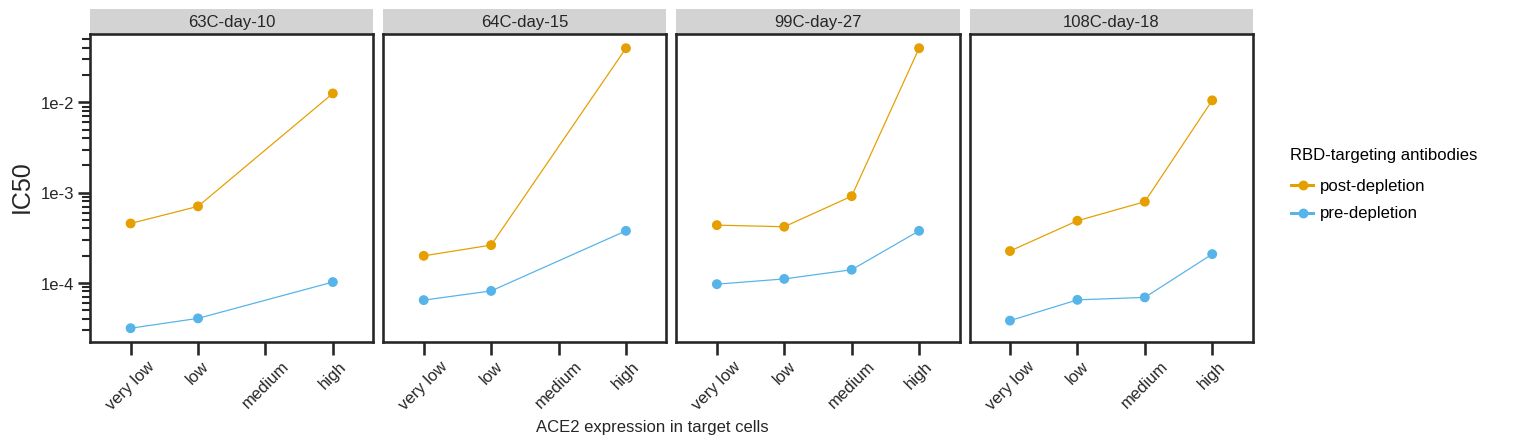

In [12]:
IC50 = (ggplot(fitparams, aes(x='category', y='ic50', colour='RBD-targeting antibodies', group = 'RBD-targeting antibodies')) +
              geom_point(size=3) +
        geom_line(alpha=1) +
             theme(figure_size=(15,1*df['serum'].nunique()),
                   axis_text=element_text(size=12),
                   axis_text_x=element_text(size=12, angle= 45),
                   legend_text=element_text(size=12),
                   legend_title=element_text(size=12),
                   axis_title_x=element_text(size=12),
                   strip_text = element_text(size=12)
                  ) +
              facet_wrap('sample', ncol = 4)+
              scale_y_log10(name='IC50') +
              xlab('ACE2 expression in target cells') +
             scale_color_manual(values=CBPALETTE[1:])
                 )

_ = IC50.draw()
IC50.save(f'./{resultsdir}/IC50.pdf')

## Plot NT50 values

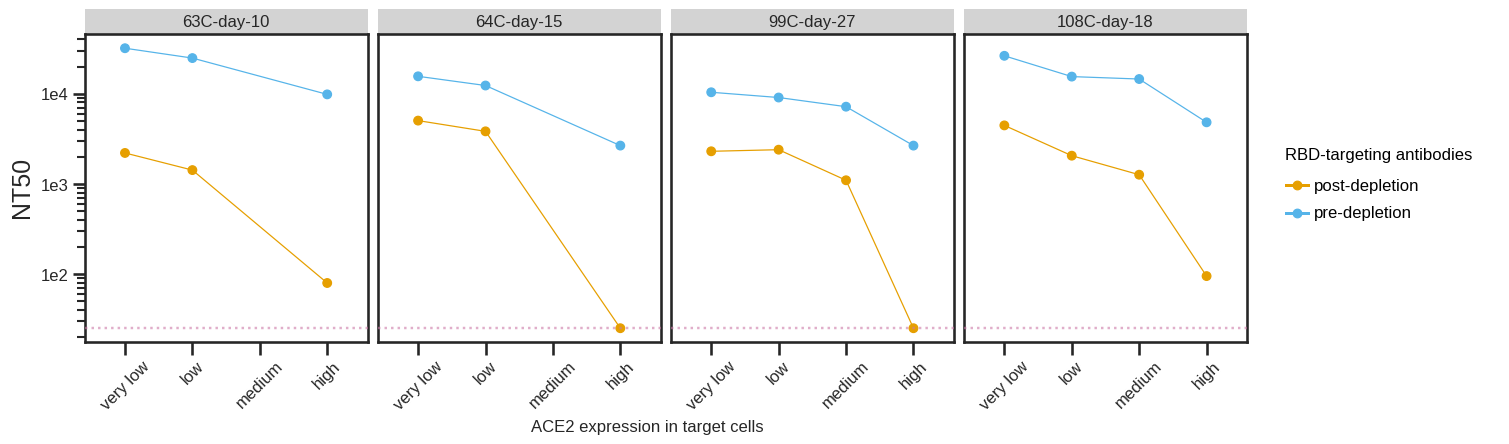

In [13]:
NT50 = (ggplot(fitparams, aes(x='category', y='NT50', colour='RBD-targeting antibodies', group = 'RBD-targeting antibodies')) +
              geom_point(size=3) +
             geom_line(alpha=1) +
             theme(figure_size=(15,1*df['serum'].nunique()),
                   axis_text=element_text(size=12),
                   axis_text_x=element_text(size=12, angle= 45),
                   legend_text=element_text(size=12),
                   legend_title=element_text(size=12),
                   axis_title_x=element_text(size=12),
                   strip_text = element_text(size=12)
                  ) +
                geom_hline(yintercept=config['NT50_LOD'], 
                linetype='dotted', 
                size=1, 
                alpha=0.6, 
                color=CBPALETTE[7]) +
              facet_wrap('sample', ncol = 4)+
              scale_y_log10(name='NT50') +
              xlab('ACE2 expression in target cells') +
             scale_color_manual(values=CBPALETTE[1:])
                 )

_ = NT50.draw()
NT50.save(f'./{resultsdir}/NT50.pdf')
NT50.save('NT50_all_samples.png', dpi=300)


## Plot neut curves for all samples

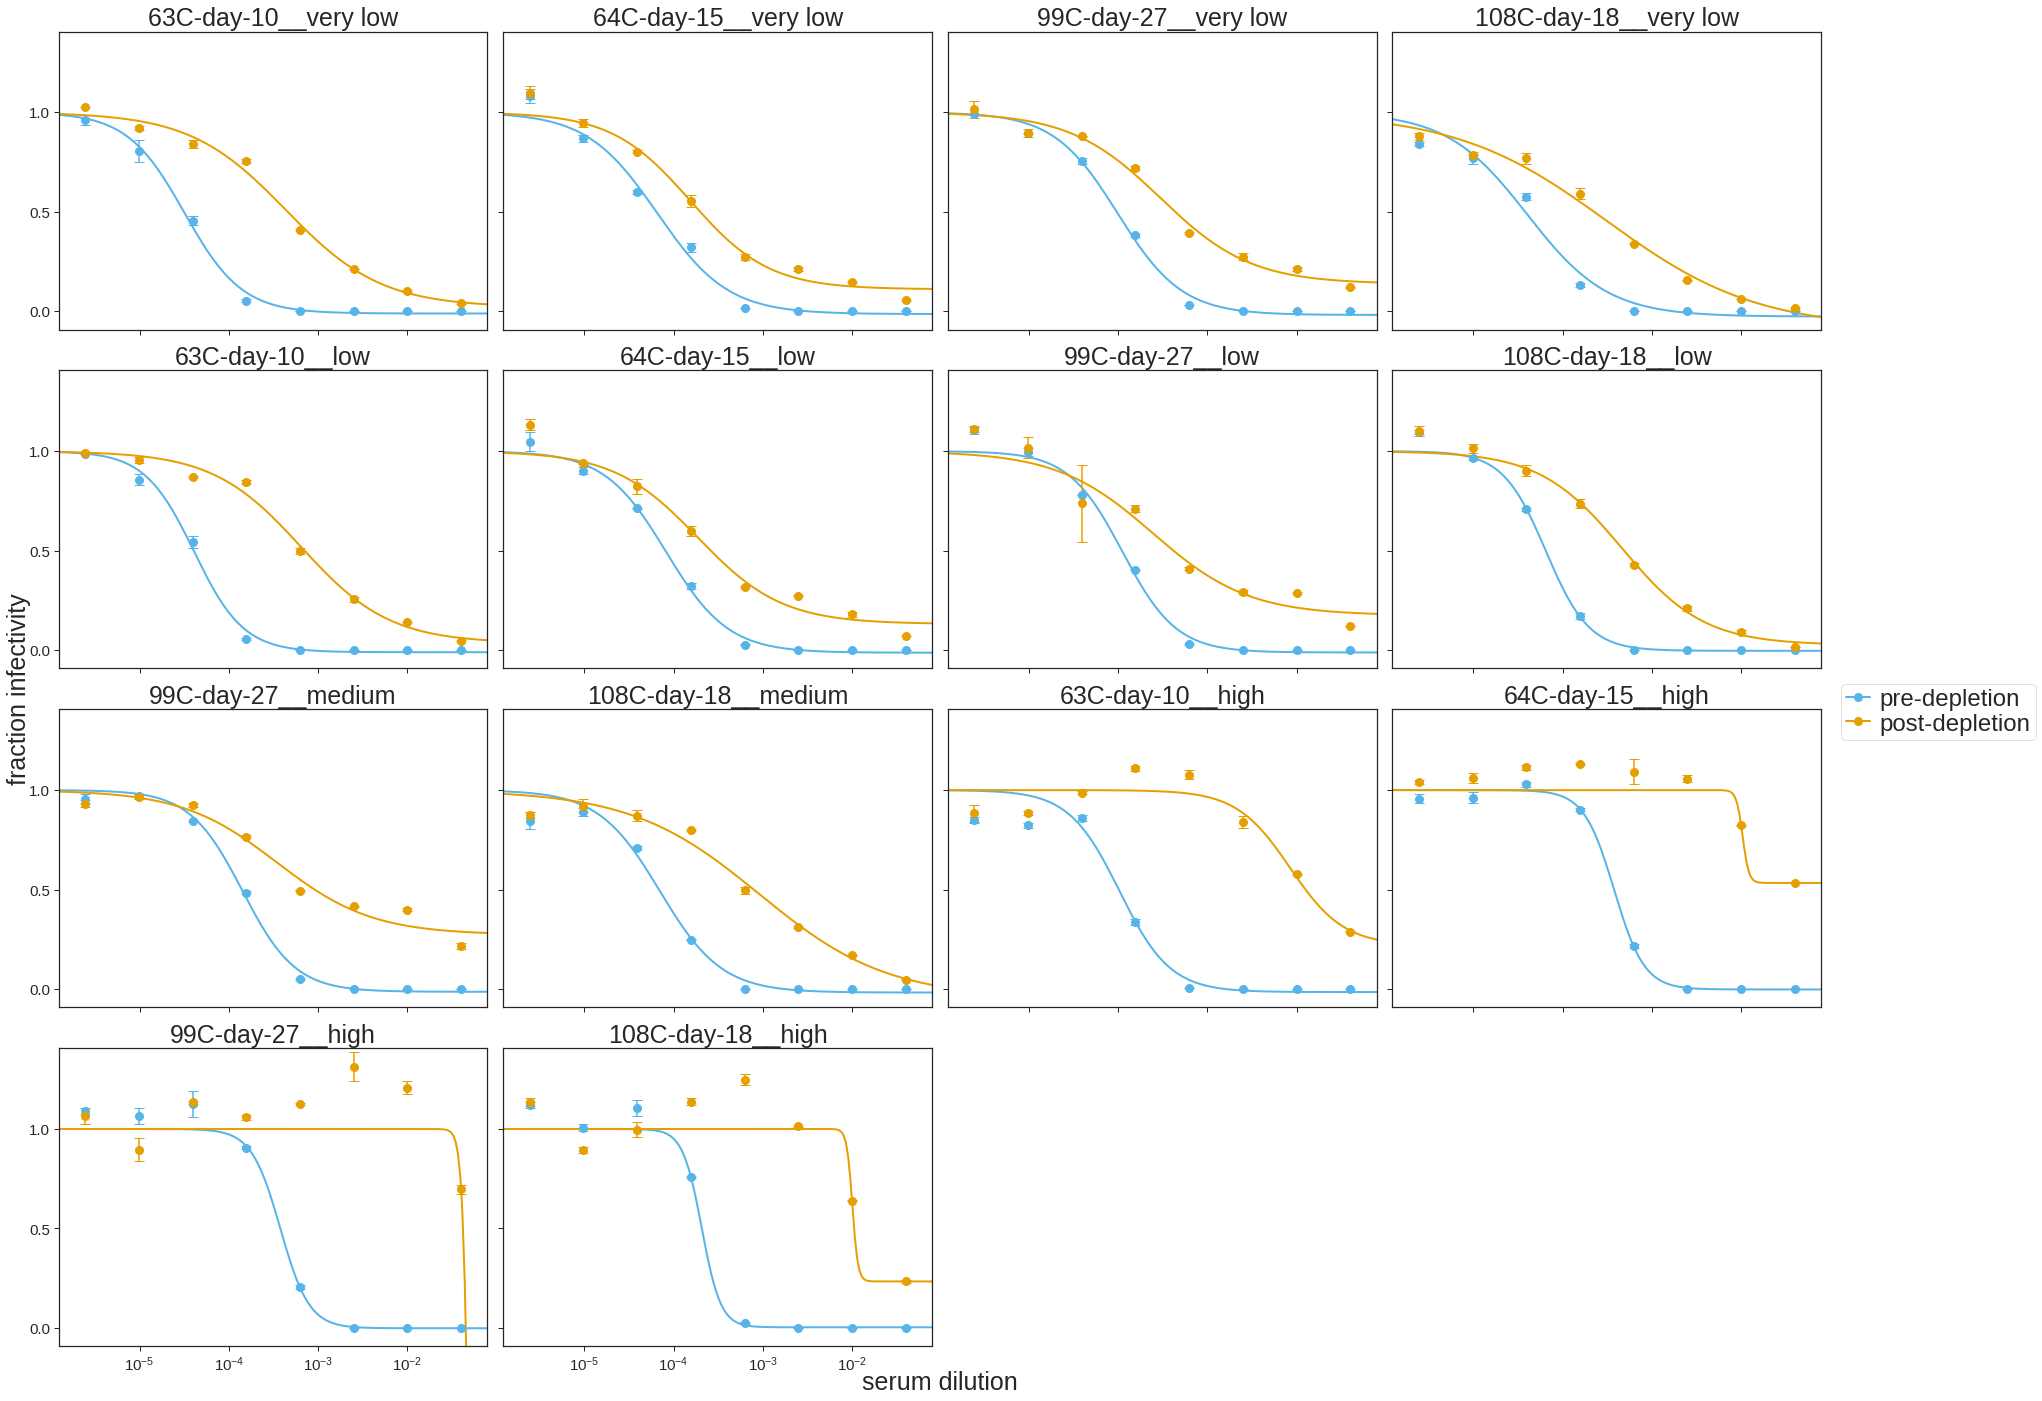

In [14]:
fig, axes = fits.plotSera(
                          xlabel='serum dilution',
                          ncol=4,
                          widthscale=2,
                          heightscale=2,
                          titlesize=25, labelsize=25, ticksize=15, legendfontsize=24, yticklocs=[0,0.5,1],
                          markersize=8, linewidth=2,
                          virus_to_color_marker={
                          'pre-depletion': ('#56B4E9', 'o'),
                          'post-depletion': ('#E69F00', 'o')}
                         )